# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten, AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path='/datasets/faces/'
labels = pd.read_csv(f'{path}/labels.csv')

In [3]:
train_datagen  = ImageDataGenerator(validation_split=0.25,
                                         rescale=1/255.,
                                         rotation_range=20)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

Found 5694 validated image filenames.


In [4]:
test_datagen  = ImageDataGenerator(validation_split=0.25,
                                   rescale=1/255.)
test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

Found 1897 validated image filenames.


Всего в выборке 7591 изображений.

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


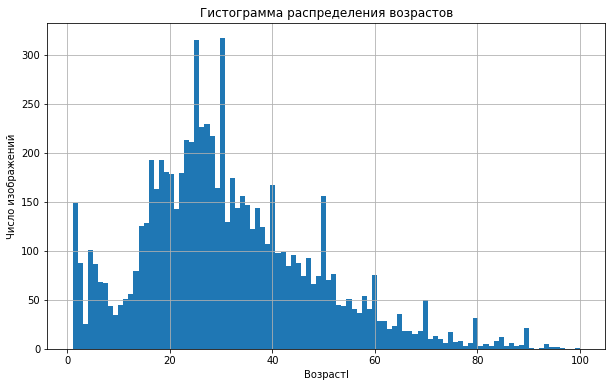

In [13]:
ax = labels.real_age.hist(bins=100, figsize=(10,6))
ax.set_xlabel("Возрастl")
ax.set_ylabel("Число изображений")
ax.set_title('Гистограмма распределения возрастов');

В датасете представлены возраста от 1 до 100 лет.   
Большинство фото принадлежат людям 20-40 лет, также довольно много фото детей до 10 лет.
У распределения два пика: в 1 и в примерно в 30.

Есть пики в круглых числах - 20, 25, 30, 40...  
Есть возможнось, что люди часто делают фото на юбилей. И выкладывают эти фото в интернет с указанием точного возраста. Что позволяет легко собрать такие фото в датасет.

In [8]:
features, target = next(train_datagen_flow)

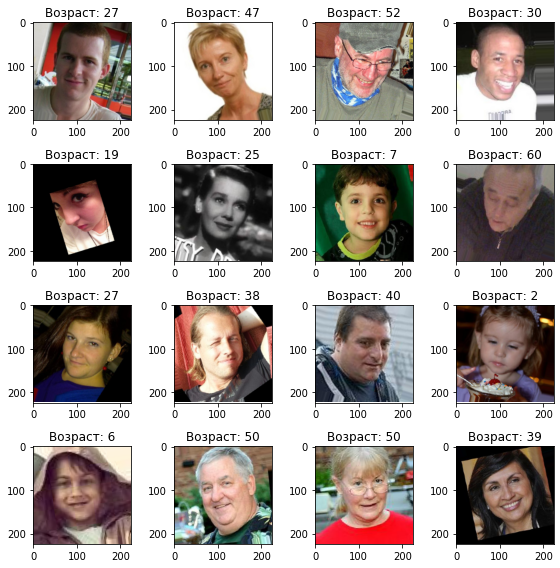

In [9]:
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(2*cols,2*rows))
i, j = 0, 0
for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
        ax.imshow(features[i + j*rows])
        ax.set_title('Возраст: {}'.format(target[i + j*rows]))
plt.tight_layout()
plt.show()

Как видно, некоторые лица находятся под углом к вертикали. Поэтому я добавила в тренировочную выборку поворот на 20°, чтобы модель лучше распознавала их.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np

def load_train(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    train_datagen  = ImageDataGenerator(validation_split=0.25,
                                         rescale=1/255.,
                                         rotation_range=20)
    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory= f'{path}/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    test_datagen  = ImageDataGenerator(validation_split=0.25,
                                       rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory= f'{path}/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)     
    model = Sequential()
    model.add(backbone)
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu')) 
    optimizer = Adam(lr=0.0003)
    model.compile(loss='mean_squared_error', metrics = ['mean_absolute_error'], optimizer=optimizer)
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=6,
                steps_per_epoch=None, validation_steps=None):   
    model.fit(train_data,
              validation_data=test_data,
              verbose=2, epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps)       
    return model 

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/6
178/178 - 110s - loss: 202.9018 - mean_absolute_error: 10.4832 - val_loss: 632.1061 - val_mean_absolute_error: 20.1589
Epoch 2/6
178/178 - 92s - loss: 102.4210 - mean_absolute_error: 7.6552 - val_loss: 323.9647 - val_mean_absolute_error: 13.3221
Epoch 3/6
178/178 - 89s - loss: 80.2610 - mean_absolute_error: 6.7728 - val_loss: 319.5228 - val_mean_absolute_error: 13.1768
Epoch 4/6
178/178 - 93s - loss: 62.2699 - mean_absolute_error: 6.0316 - val_loss: 190.3392 - val_mean_absolute_error: 10.1980
Epoch 5/6
178/178 - 97s - loss: 54.1694 - mean_absolute_error: 5.5874 - val_loss: 96.6063 - val_mean_absolute_error: 7.4358
Epoch 6/6
178/178 - 95s - loss: 48.3315 - mean_absolute_error: 5.3243 - val_loss: 85.2354 - val_mean_absolute_error: 6.9199
60/60 - 11s - loss: 85.2354 - mean_absolute_error: 6.9199
Test MAE: 6.9199

```

## Анализ обученной модели

Я использовала модель ResNet50 и добавила слой Dropout, чтобы избежать переобучения.  
Для оптимизотора Adam подобрала скорость обучения равной 0.0003, показавший хороший результат.  
Для финального слоя использую функцию активации ReLu, так как возраст всегда положиельный.  

Модель показала хороший результат - MAE немного меньше 7.